### Generating a bit-pattern with predefined parameters using Genetic Algorithm

In [1]:
from deap import base, creator, tools
from random import randint, random, seed

import numpy as np

In [2]:
def eval_func(individual):
    #Evaluation function
    target_sum = 45
    return len(individual) - abs(sum(individual) - target_sum),

def create_toolbox(num_bits):
    creator.create('FitnessMax', base.Fitness, weights = (1.0,))
    creator.create('Individual', list, fitness = creator.FitnessMax)

    toolbox = base.Toolbox()

    toolbox.register('attr_bol', randint, 0, 1)
    toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.attr_bol, num_bits)
    toolbox.register('population', tools.initRepeat, list, toolbox.individual)
    
    toolbox.register('evaluate', eval_func)
    toolbox.register('mate', tools.cxTwoPoint)
    toolbox.register('mutate', tools.mutFlipBit, indpb = 0.05)
    toolbox.register('select', tools.selTournament, tournsize = 3)
    
    return toolbox

In [3]:
num_bits = 75

toolbox = create_toolbox(num_bits)

In [4]:
#Seed the random number generator to get repeatable results
seed(7)

population = toolbox.population(n = 500)

In [5]:
probab_crossing, probab_mutating = 0.5, 0.2

num_generations = 60 #The more the generations, the more cycles to improve the fitness of the population

In [6]:
print('Starting the evolution process')

#Evaluate the entire population
fitnesses = list(map(toolbox.evaluate, population))
for ind, fit in zip(population, fitnesses):
    ind.fitness.values = fit
    
print(f'Evaluated {len(population)} individuals')

Starting the evolution process
Evaluated 500 individuals


In [7]:
#Iterate through generations
for g in range(num_generations):
    print(f'Generation {g}')
    
    #Select the next generation individuals
    offspring = toolbox.select(population, len(population))
    
    #Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))
    
    #Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        #Cross two individuals
        if random() < probab_crossing:
            toolbox.mate(child1, child2)
            
            #Forget the fitness values of the children
            del child1.fitness.values
            del child2.fitness.values
            
    for mutant in offspring:
        #Mutate an individual
        if random() < probab_mutating:
            toolbox.mutate(mutant)
            del mutant.fitness.values
            
    #Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
        
    print(f'Evaluated {len(invalid_ind)} individuals')
    
    #Replace the entire population with the offspring
    population[:] = offspring
    
    #Gather all fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in population]
    
    mean = np.mean(fits)
    std = np.std(fits)
    
    print(f'Min = {min(fits)}, Max = {max(fits)}')
    print(f'Average = {round(mean, 2)}, Standard deviation = {round(std, 2)}\n')
    
print('\nEnd of Evolution')

Generation 0
Evaluated 297 individuals
Min = 58.0, Max = 75.0
Average = 70.43, Standard deviation = 2.91

Generation 1
Evaluated 303 individuals
Min = 63.0, Max = 75.0
Average = 72.44, Standard deviation = 2.16

Generation 2
Evaluated 310 individuals
Min = 65.0, Max = 75.0
Average = 73.31, Standard deviation = 1.6

Generation 3
Evaluated 273 individuals
Min = 67.0, Max = 75.0
Average = 73.76, Standard deviation = 1.41

Generation 4
Evaluated 309 individuals
Min = 68.0, Max = 75.0
Average = 73.87, Standard deviation = 1.35

Generation 5
Evaluated 312 individuals
Min = 68.0, Max = 75.0
Average = 73.83, Standard deviation = 1.36

Generation 6
Evaluated 308 individuals
Min = 67.0, Max = 75.0
Average = 73.76, Standard deviation = 1.5

Generation 7
Evaluated 314 individuals
Min = 67.0, Max = 75.0
Average = 73.85, Standard deviation = 1.39

Generation 8
Evaluated 309 individuals
Min = 66.0, Max = 75.0
Average = 73.84, Standard deviation = 1.48

Generation 9
Evaluated 288 individuals
Min = 68.

In [8]:
best_ind = tools.selBest(population, 1)[0]

print(f'Best Individual = {best_ind}')
print(f'Number of ones = {sum(best_ind)}')

Best Individual = [1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1]
Number of ones = 45


### Visualizing the evolution

In [9]:
import matplotlib.pyplot as plt
from deap import algorithms, benchmarks, cma

In [10]:
def create_toolbox(stategy):
    creator.create('FitnessMin', base.Fitness, weights = (-1.0,))
    creator.create('Individual', list, fitness = creator.FitnessMin)
    
    toolbox = base.Toolbox()
    toolbox.register('evaluate', benchmarks.rastrigin)
    
    np.random.seed(7)
    
    toolbox.register('generate', strategy.generate, creator.Individual)
    toolbox.register('update', strategy.update)
    
    return toolbox

In [11]:
num_individuals = 10
num_generations = 125

In [12]:
##### Create a strategy using CMA-ES algorithm
strategy = cma.Strategy(centroid = [5.0] * num_individuals, sigma = 5.0, lambda_ = 20 * num_individuals)

toolbox = create_toolbox(strategy)

C:\Users\U\anaconda3\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [13]:
hall_of_fame = tools.HallOfFame(1)

In [14]:
#Register the relevant stats
stats = tools.Statistics(lambda x: x.fitness.values)

stats.register('avg', np.mean)
stats.register('std', np.std)
stats.register('min', np.min)
stats.register('max', np.max)

In [15]:
#Create a logbook to keep track of the evolution records
logbook = tools.Logbook()
logbook.header = 'gen', 'evals', 'avg', 'std', 'min', 'max'

In [16]:
#Define objects that will compile the data which will be plotted
sigma = np.ndarray((num_generations, 1))
axis_ratio = np.ndarray((num_generations, 1))
fbest = np.ndarray((num_generations, 1))

diagD = np.ndarray((num_generations, num_individuals))
best = np.ndarray((num_generations, num_individuals))
std = np.ndarray((num_generations, num_individuals))

In [17]:
for gen in range(num_generations):
    #Generate a new population
    population = toolbox.generate()
    
    #Evaluate the individuals
    fitnesses = toolbox.map(toolbox.evaluate, population)
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit
        
    #Update the strategy with the evaluated individuals
    toolbox.update(population)
    #Update the hall of fame and statistics with the currently evaluated population
    hall_of_fame.update(population)
    record = stats.compile(population)
    logbook.record(evals = len(population), gen = gen, **record)
    
    print(logbook.stream)
    
    #Save more data along the evolution for plotting
    sigma[gen] = strategy.sigma
    axis_ratio[gen] = max(strategy.diagD)**2 / min(strategy.diagD)**2
    fbest[gen] = hall_of_fame[0].fitness.values
    
    diagD[gen, :num_individuals] = strategy.diagD**2
    best[gen, :num_individuals] = hall_of_fame[0]
    std[gen, :num_individuals] = np.std(population, axis = 0)

gen	evals	avg    	std   	min    	max    
0  	200  	576.281	188.36	217.082	1199.71
1  	200  	659.389	250.543	196.583	1869.02
2  	200  	683.641	273.081	199.455	1770.65
3  	200  	503.933	215.326	111.298	1579.3 
4  	200  	373.124	133.046	149.47 	790.899
5  	200  	274.092	75.4405	131.117	585.433
6  	200  	232.624	61.2622	91.7121	426.666
7  	200  	201.117	49.8303	88.8185	373.543
8  	200  	178.645	39.9533	85.0531	326.209
9  	200  	159.211	31.3781	87.4824	261.132
10 	200  	144.561	31.3488	54.0743	274.877
11 	200  	136.791	30.8796	63.6032	240.739
12 	200  	125.691	24.1975	70.4913	190.684
13 	200  	122.293	21.2274	50.6409	177.483
14 	200  	124.132	25.4931	67.9873	199.296
15 	200  	119.295	26.9804	46.3411	205.331
16 	200  	115.614	24.8993	56.0033	176.702
17 	200  	113.417	21.9789	61.4999	170.156
18 	200  	112.419	21.2823	50.2455	190.677
19 	200  	111.543	22.5016	48.153 	166.2  
20 	200  	106.044	21.1602	32.1864	171.899
21 	200  	107.301	23.3864	52.8601	163.617
22 	200  	109.628	23.1008	51.1226	18

In [18]:
#Define the x-axis which will be the number of evaluations and plot the stats
x = list(range(0, strategy.lambda_ * num_generations, strategy.lambda_))

avg, max_, min_ = logbook.select('avg', 'max', 'min')

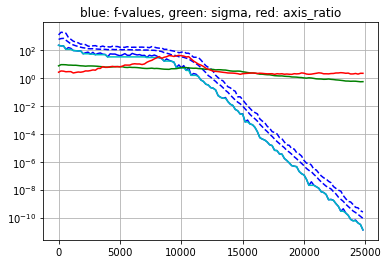

In [19]:
plt.figure()
plt.title('blue: f-values, green: sigma, red: axis_ratio')
plt.grid(True)

plt.semilogy(x, avg, '--b')
plt.semilogy(x, max_, '--b')
plt.semilogy(x, min_, '-b')

plt.semilogy(x, fbest, '-c')
plt.semilogy(x, sigma, '-g')
plt.semilogy(x, axis_ratio, '-r');

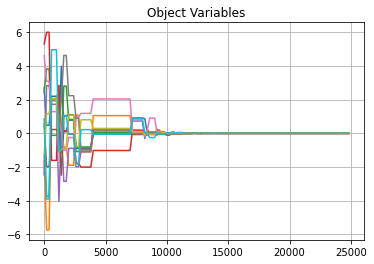

In [20]:
#Plotting the progress

plt.figure()
plt.title('Object Variables')
plt.grid(True)

plt.plot(x, best);

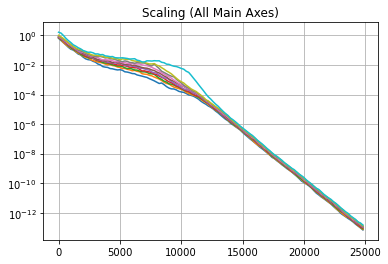

In [21]:
plt.figure()
plt.title('Scaling (All Main Axes)')
plt.grid(True)

plt.semilogy(x, diagD);

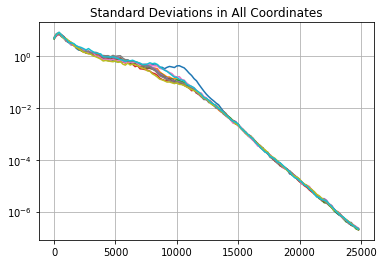

In [22]:
plt.figure()
plt.title('Standard Deviations in All Coordinates')
plt.grid(True)

plt.semilogy(x, std);

### Solving the symbol regression problem using Genetic programming

In [23]:
import operator
import math
import random

import numpy as np
from deap import gp

In [24]:
def division_operator(numerator, denominator):
    if denominator == 0:
        return 1
    else:
        return numerator / denominator

In [25]:
def eval_func(individual, points):
    #Transform the tree expression in a callable form
    func = toolbox.compile(expr = individual)
    
    mse = ((func(x) - (2*x**3 - 3*x**2 + 4*x-1))**2 for x in points)
    
    return math.fsum(mse) / len(points),

In [26]:
def create_toolbox():
    pset = gp.PrimitiveSet('MAIN', 1)
    
    pset.addPrimitive(operator.add, 2)
    pset.addPrimitive(operator.sub, 2)
    pset.addPrimitive(operator.mul, 2)
    pset.addPrimitive(division_operator, 2)
    
    pset.addPrimitive(operator.neg, 1)
    pset.addPrimitive(math.cos, 1)
    pset.addPrimitive(math.sin, 1)
    
    pset.addEphemeralConstant('rand101', lambda: random.randint(-1, 1)) #Cos the constant terminals can take -1, 0, or 1
    
    #Changing the name from default 'ARGx' to 'x'
    pset.renameArguments(ARG0 = 'x')
    
    creator.create('FitnessMin', base.Fitness, weights = (-1.0, ))
    creator.create('Individual', gp.PrimitiveTree, fitness = creator.FitnessMin)
    
    toolbox = base.Toolbox()
    
    toolbox.register('expr', gp.genHalfAndHalf, pset = pset, min_ = 1, max_ = 2)
    toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.expr)
    toolbox.register('population', tools.initRepeat, list, toolbox.individual)
    
    toolbox.register('compile', gp.compile, pset = pset)
    toolbox.register('evaluate', eval_func, points = [x/10. for x in range(-10, 10)])
    
    toolbox.register('select', tools.selTournament, tournsize = 3)
    toolbox.register('mate', gp.cxOnePoint)
    toolbox.register('expr_mut', gp.genFull, min_ = 0, max_ = 2)
    toolbox.register('mutate', gp.mutUniform, expr = toolbox.expr_mut, pset = pset)
    
    toolbox.decorate('mate', gp.staticLimit(key = operator.attrgetter('height'), max_value = 17))
    toolbox.decorate('mutate', gp.staticLimit(key = operator.attrgetter('height'), max_value = 17))
    
    return toolbox

In [27]:
random.seed(7)

toolbox = create_toolbox()

C:\Users\U\anaconda3\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\U\anaconda3\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [28]:
population = toolbox.population(n = 450)
hall_of_fame = tools.HallOfFame(1)

In [29]:
stats_fit = tools.Statistics(lambda x: x.fitness.values)
stats_size = tools.Statistics(len)

mstats = tools.MultiStatistics(fitness = stats_fit, size = stats_size)
mstats.register('avg', np.mean)
mstats.register('std', np.std)
mstats.register('min', np.min)
mstats.register('max', np.max)

In [30]:
probab_crossover = 0.4
probab_mutate = 0.2
num_generations = 60

In [31]:
population, log = algorithms.eaSimple(population, toolbox, probab_crossover, probab_mutate, num_generations,
                                     stats = mstats, halloffame = hall_of_fame, verbose = True)

   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max    	min    	nevals	std    	avg    	gen	max	min	nevals	std    
0  	450   	18.6918	0  	47.1923	7.39087	450   	6.27543	3.73556	0  	7  	2  	450   	1.62449
1  	251   	15.4572	1  	41.3823	4.46965	251   	4.54993	3.80222	1  	12 	1  	251   	1.81316
2  	236   	13.2545	2  	37.7223	4.46965	236   	4.06145	3.96889	2  	12 	1  	236   	1.98861
3  	251   	12.2299	3  	60.828 	4.46965	251   	4.70055	4.19556	3  	12 	1  	251   	1.9971 
4  	235   	11.001 	4  	47.1923	4.46965	235   	4.48841	4.84222	4  	13 	1  	235   	2.17245
5  	229   	9.44483	5  	31.478 	4.46965	229   	3.8796 	5.56   	5  	19 	1  	229   	2.43168
6  	225   	8.35975	6  	22.0546	3.02133	225   	3.40547	6.38889	6  	15 	1  	225   	2.40875
7  	237   	7.99309	7  	31.1356	1.81133	237   	4.08463	7.14667	7  	16 	1  	